# RELATIVE STRENGTH (RS)

In [1]:
import pandas as pd
import itable
import ffn
import talib
import datetime as dt

%matplotlib inline

def side_by_side(*objs, **kwds):
    from pandas.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))

In [2]:
def monthly_return_table (daily_prices) :
    #monthly_returns = daily_prices.resample('M').last().pct_change()
    monthly_returns = daily_prices.resample('M', how='last').pct_change()
    df = pd.DataFrame(monthly_returns.values, columns=['Data'])
    df['Month'] = monthly_returns.index.month
    df['Year']= monthly_returns.index.year
    table = df.pivot_table(index='Year', columns='Month').fillna(0).round(4) * 100
    #annual_returns = daily_prices.resample('12M').last().pct_change()[1:].values.round(4) * 100
    annual_returns = daily_prices.resample('12M', how='last').pct_change()[1:].values.round(4) * 100
    if len(table) > len(annual_returns) :
        table = table[1:]
    table['Annual Returns'] = annual_returns
    return table

In [3]:
def endpoints(start=None, end=None, period='m', trading_days=None) :
    
    if trading_days is not None:
        dates = trading_days
# the following 2 lines cause python 3.4.2 to crash, so removed them
#    elif start is not None and end is not None:
#        dates = tradingcalendar.get_trading_days(start, end)
    else:
        print ('\n** ERROR : must either provide pandas series (or df) of trading days \n')
        print ('           or a start and end date\n')
    
    if isinstance(period, int) :
        dates = [dates[i] for i in range(0, len(dates), period)]
    else :    
        if period == 'm' : months = 1
        elif period == 'q' : months = 3
        elif period == 'b' : months = 6
        elif period == 'y' : months = 12           
            
        e_dates = [dates[i - 1] for i in range(1,len(dates))\
                          if dates[i].month > dates[i-1].month\
                          or dates[i].year > dates[i-1].year ]+ list([dates[-1]])
        dates = [e_dates[i] for i in range(0,len(e_dates),months)]
    
    return dates

In [4]:
# THIS ONE MATCHES PV
# SEE PV backtest :https://goo.gl/lBR4K9
# AND spreadsheet : https://goo.gl/8KGp58
# and Quantopian backtest : https://goo.gl/xytT5L

def backtest(prices, weights, capital, offset=1, commission=0.) :
    rebalance_dates = weights.index
    buy_dates = [prices.index[d + offset] for d in range(len(prices.index)-1) if prices.index[d] in rebalance_dates ]
    print ('FIRST BUY DATE = {}\n'.format(buy_dates[0]))
    p_holdings = pd.DataFrame(0, index=prices.index, columns=prices.columns)
    cash = 0.
    for i, date in enumerate(prices.index):
        if date in rebalance_dates :
#             print ('--------------------------------------------------------------------') 
            new_weights = weights.loc[date]
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
        if date in buy_dates :           
            if date == buy_dates[0] :
                p_holdings.loc[date] = (capital * weights.iloc[0] / prices.loc[date])
#                 print ('INIT', cash, p_holdings.iloc[i-1],prices.loc[date], new_weights)
            else :
                portfolio_value = cash + (p_holdings.iloc[i - 1] * prices.loc[date]).sum() * new_weights
                p_holdings.iloc[i] = (portfolio_value / prices.loc[date]).fillna(0)
#                 print ('{} BUY \n{}\n{}\n{}\n{}\n{}\nHOLDINGS\n{}\n'.format(date,cash,portfolio_value,p_holdings.iloc[i-1],
#                                                                     prices.loc[date],new_weights,p_holdings.iloc[i]))
                cash = (portfolio_value - p_holdings.iloc[i] * prices.loc[date]).sum()
#                 print ('{}\nPORTFOLIO VALUE\n{}\nCASH = {}'.format(date, portfolio_value,cash))
        else :
            p_holdings.iloc [i] = p_holdings.iloc [i - 1]
            #print ('{} HOLDINGS UNCHANGED'.format(date))

    p_value = (p_holdings * prices).sum(1)[p_holdings.index>=buy_dates[0]]
#     print(p_holdings, )
    p_weights = p_holdings.mul(prices).div(p_holdings.mul(prices).sum(axis=1), axis=0).fillna(0)
    
    return p_value, p_holdings, p_weights

# DM0003(VCP001)

In [ ]:
symbols =['VCVSX','VGHCX', 'VWEHX','VFIIX','DRGIX','VWAHX']
# symbols =['CWB','VHT', 'HYG','HYD','MBB','IEF']
cash_proxy = 'VFIIX'
# cash_proxy = 'SHY'
risk_free = 0

rs_lookback = 1
risk_lookback = 1
n_top = 2

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
MA = pd.rolling_mean(prices_m,2)[symbols]
# absolute_momentum_rule = returns > 0
absolute_momentum_rule = MA > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

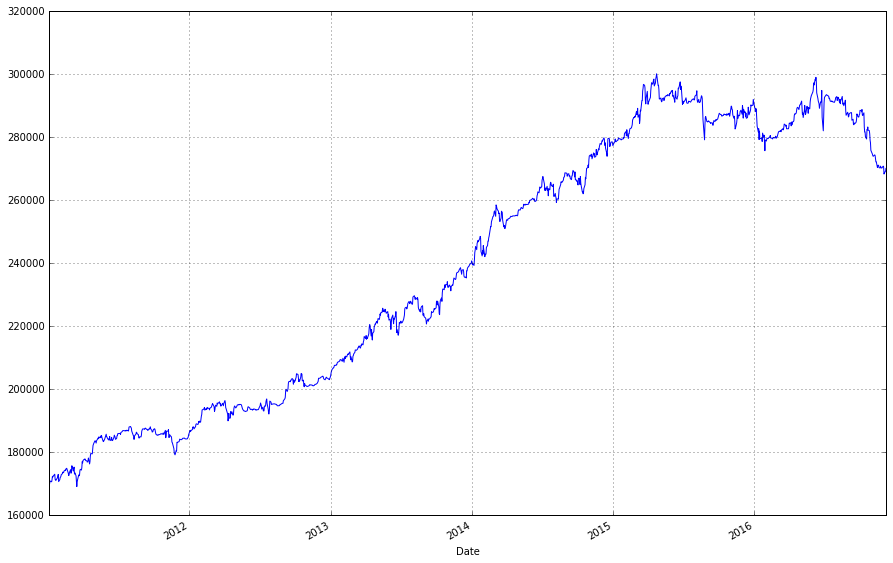

In [6]:
import datetime as dt
p_value[p_value.index > dt.datetime(2011,1,1)].plot(figsize=(15,10), grid=True)

In [8]:
p_weights[p_weights.index > dt.datetime(2011,1,1)].loc[rebalance_dates].round(3).dropna()[:5]

,CWB,IEF,SHY,MBB,HYG,HYD
Date,,,,,,
2011-01-31,0.5,0.0,0,0.0,0.5,0.0
2011-02-28,0.5,0.0,0,0.0,0.0,0.5
2011-03-31,0.0,0.0,0,0.5,0.5,0.0
2011-04-29,0.5,0.5,0,0.0,0.0,0.0
2011-05-31,0.0,0.5,0,0.0,0.0,0.5


In [11]:
p_holdings[p_holdings.index > dt.datetime(2011,1,1)].loc[rebalance_dates].round(2).dropna()[:5]

,CWB,IEF,SHY,MBB,HYG,HYD
Date,,,,,,
2011-01-31,207.86,0.00,0,0.00,98.91,0.00
2011-02-28,207.40,0.00,0,0.00,0.00,304.82
2011-03-31,0.00,0.00,0,69.14,98.74,0.00
2011-04-29,205.95,77.62,0,0.00,0.00,0.00
2011-05-31,0.00,76.67,0,0.00,0.00,304.79


In [12]:
prices_m[prices_m.index > dt.datetime(2011,1,1)][:5]

,CWB,IEF,SHY,MBB,HYG,HYD
Date,,,,,,
2011-01-31,30.797647,83.492345,81.687149,93.520028,64.719870,20.749959
2011-02-28,31.376494,83.318340,81.587986,93.538675,65.648892,21.349132
2011-03-31,31.378728,83.189543,81.481940,93.792456,65.676742,21.199888
2011-04-29,31.929808,84.721287,81.917182,94.916737,66.725964,21.421149
2011-05-31,31.932052,86.844055,82.215374,95.879471,66.814904,21.845546


In [13]:
MA[MA.index > dt.datetime(2011,1,1)][:5]

,CWB,HYG,HYD,MBB,IEF
Date,,,,,
2011-01-31,30.630671,64.194524,20.890112,93.471361,83.501244
2011-02-28,31.087070,65.184381,21.049546,93.529351,83.405342
2011-03-31,31.377611,65.662817,21.274510,93.665565,83.253941
2011-04-29,31.654268,66.201353,21.310519,94.354596,83.955415
2011-05-31,31.930930,66.770434,21.633348,95.398104,85.782671


In [7]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1987-04-30 00:00:00 - 2016-12-06 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
2601.66%            1.57  11.78%  -19.31%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y     5y     10y    incep.
------  ------  ------  ------  ------  -----  -----  -----  --------
-0.17%  -6.15%  -9.48%  -7.02%  -6.49%  4.34%  8.02%  9.64%  11.78%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.57     1.57       1.45
mean    11.40%   11.43%     12.57%
vol     7.27%    7.27%      8.69%
skew    -1.05    -0.38      0.00
kurt    26.42    3.23       -0.30
best    5.63%    7.94%      29.92%
worst   -8.74%   -11.27%    -7.02%

Drawdowns:
max      avg       # days
-------  ------  --------
-19.31%  -1.09%     20.82

Misc:
---------------  ------
avg. up month    1.88%
avg. down month  -1.44%
up year %        96.55%
12m up %  

In [20]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

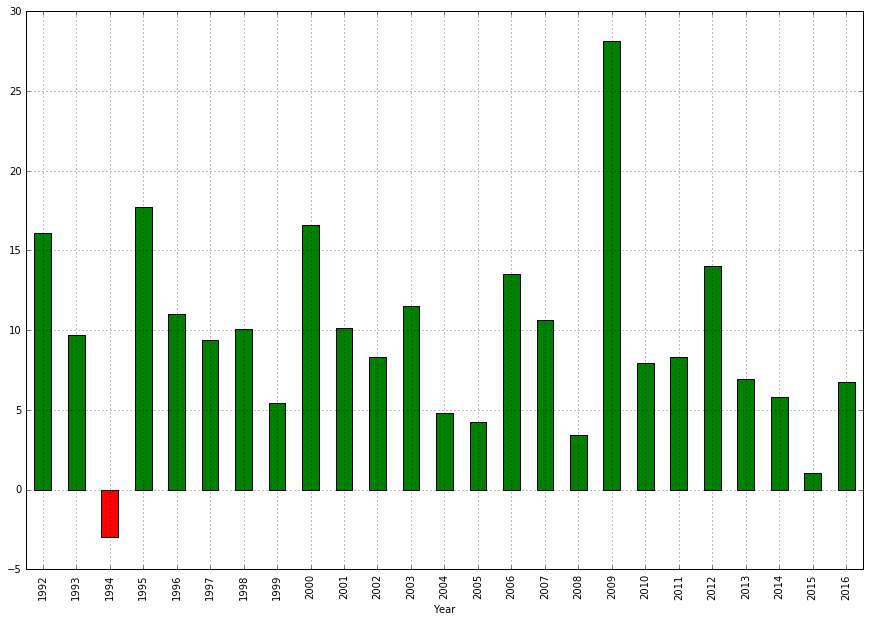

In [21]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# RS0002 (SMBS01)

In [9]:
symbols =['MMHYX','FAGIX','VFIIX']
cash_proxy = 'CASHX'
risk_free = 0

rs_lookback = 3
risk_lookback = 2
n_top = 1

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()

end_points = endpoints(period='m', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

       inception
MMHYX 1984-02-23
FAGIX 1984-02-23
VFIIX 1984-02-23


NameError: name 'endpoints' is not defined

In [7]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1984-05-31 00:00:00 - 2016-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
3650.34%            2.52  11.80%  -8.40%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y     10y     incep.
------  -----  -----  -----  -----  -----  -----  ------  --------
-0.10%  0.18%  3.01%  5.87%  7.43%  6.88%  7.38%  11.76%  11.80%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.52     1.91       1.06
mean    11.25%   11.38%     12.34%
vol     4.47%    5.96%      11.69%
skew    0.61     0.81       2.35
kurt    10.60    3.98       6.81
best    3.86%    9.07%      56.88%
worst   -2.57%   -5.33%     -0.57%

Drawdowns:
max     avg       # days
------  ------  --------
-8.40%  -0.70%     20.21

Misc:
---------------  ------
avg. up month    1.56%
avg. down month  -0.92%
up year %        96.88%
12m up %         95.79%

In [8]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

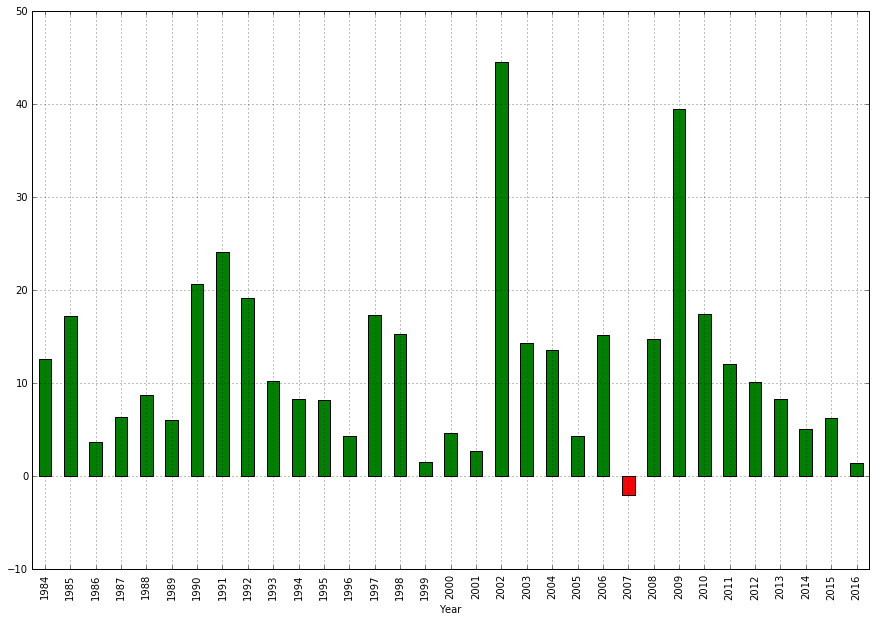

In [9]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

# RS0003 (SQBS01)

       inception
MMHYX 1984-02-23
FAGIX 1984-02-23
VFIIX 1984-02-23
FIRST BUY DATE = 2003-04-30 00:00:00



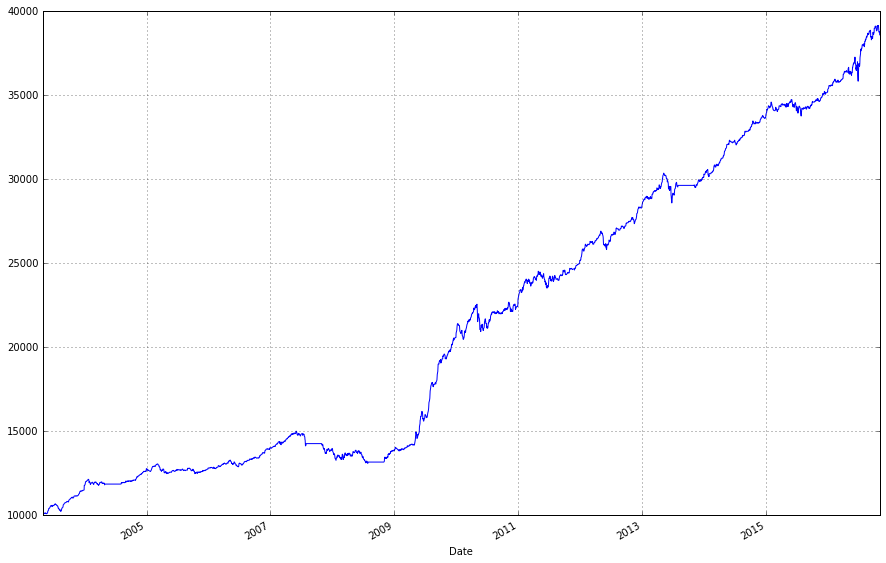

In [28]:
start = dt.datetime(2003,1,1)
end = dt.datetime(2016,11,1)

symbols =['MMHYX','FAGIX','VFIIX']
cash_proxy = 'CASHX'
risk_free = 0

rs_lookback = 1
risk_lookback =1
n_top = 1

# get data
tickers = symbols.copy()
if cash_proxy != 'CASHX' :
    tickers = list(set(tickers + [cash_proxy]))
if isinstance(risk_free, str) :
    tickers = list(set(tickers + [risk_free]))

data = pd.DataFrame (columns=tickers)
for symbol in tickers :
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
    data[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close']
         
inception_dates = pd.DataFrame([data[ticker].first_valid_index() for ticker in data.columns], 
                               index=data.keys(), columns=['inception'])

print (inception_dates)

prices = data.copy().dropna()[start:end]

end_points = endpoints(period='q', trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0
if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()
    
rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

In [29]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2003-04-30 00:00:00 - 2016-11-01 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
286.09%             2.27  10.52%  -12.72%

Annualized Returns:
mtd     3m     6m     ytd    1y      3y     5y     10y     incep.
------  -----  -----  -----  ------  -----  -----  ------  --------
-0.52%  1.44%  5.51%  9.15%  10.89%  9.20%  9.34%  11.02%  10.52%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.27     1.62       0.79
mean    10.11%   10.18%     10.14%
vol     4.45%    6.28%      12.78%
skew    -0.01    0.88       2.80
kurt    7.11     4.46       9.17
best    2.35%    9.07%      49.91%
worst   -1.93%   -5.18%     -0.55%

Drawdowns:
max      avg       # days
-------  ------  --------
-12.72%  -0.77%     24.15

Misc:
---------------  ------
avg. up month    1.55%
avg. down month  -0.94%
up year %        84.62%
12m up %        

In [30]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

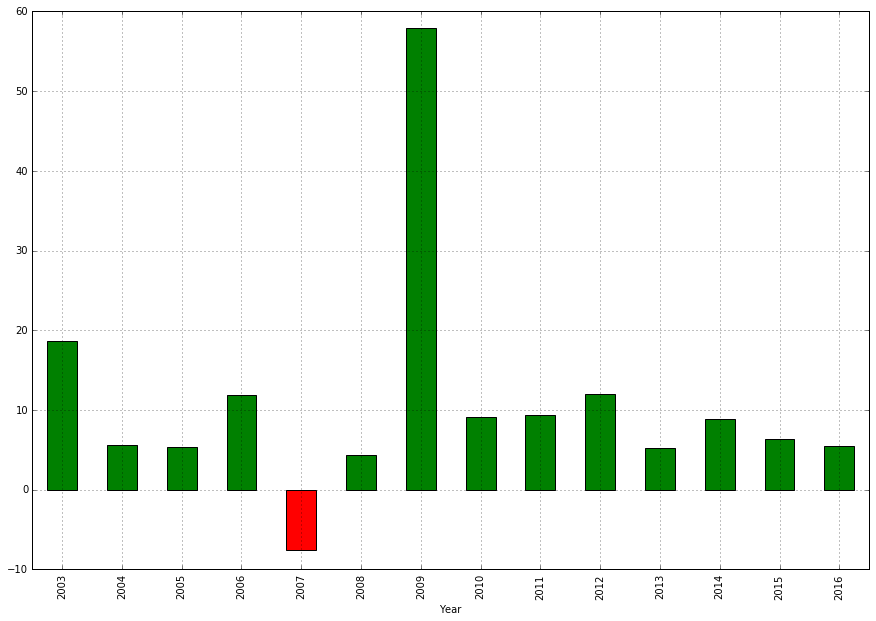

In [31]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

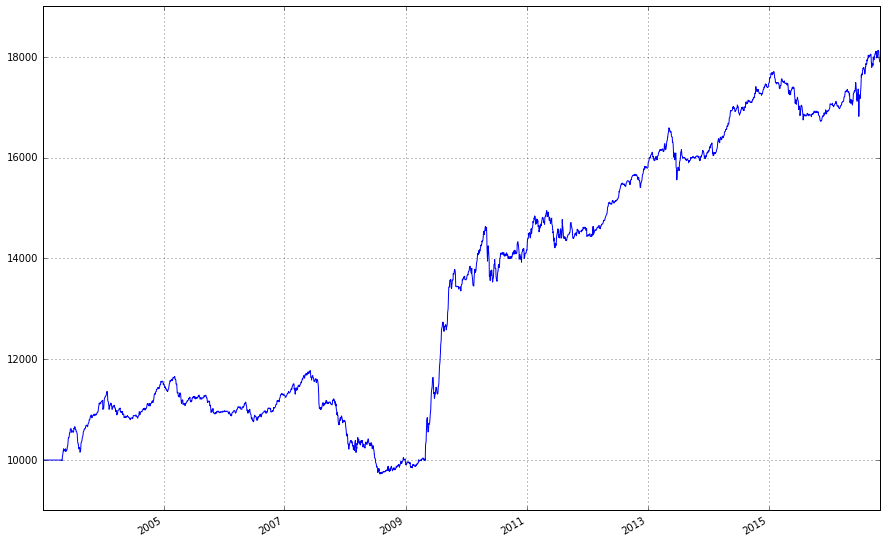

In [25]:
# Zipline results (from Pycharm)

p_value1 = pd.read_pickle('E:\\NOTEBOOKS\\Quantopian\\Strategies\\rs0003F.pkl').portfolio_value
p_value1.plot(figsize=(15, 10), grid=True)

In [109]:
start = dt.datetime(2010,4,30)
end = dt.datetime(2011,11,1)
df = pd.DataFrame(index=p_value[start:end][:-1].index)
p1 = p_value[start:end][:-1]
p2 = p_value1[start:end]
df['BT'] = (p1 / p1.iloc[0]).values
df['Z'] = (p2 / p2.iloc[0]).values

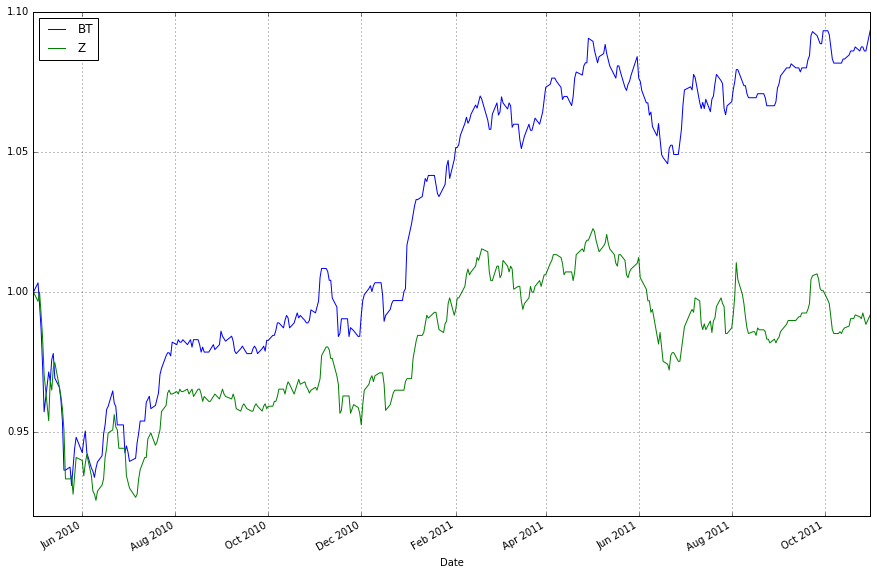

In [117]:
df.plot(figsize=(15, 10), grid=True)

In [26]:
# algo stats
ffn.calc_perf_stats(p_value1).display()

Stats for portfolio_value from 2003-01-02 21:00:00 - 2016-11-01 20:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
79.03%              1.04  4.30%   -17.45%

Annualized Returns:
mtd     3m     6m     ytd    1y     3y     5y     10y    incep.
------  -----  -----  -----  -----  -----  -----  -----  --------
-0.21%  0.95%  3.45%  5.63%  6.30%  3.79%  4.26%  4.95%  4.30%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.04     0.73       0.39
mean    4.30%    4.40%      4.29%
vol     4.15%    6.03%      11.03%
skew    -0.55    0.72       2.23
kurt    7.58     5.39       6.61
best    1.64%    8.05%      36.64%
worst   -1.94%   -5.91%     -7.76%

Drawdowns:
max      avg       # days
-------  ------  --------
-17.45%  -1.04%     46.43

Misc:
---------------  ------
avg. up month    1.25%
avg. down month  -1.01%
up year %        69.23%
12m up %     

In [27]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value1)

df.style.\
    apply(highlight_pos_neg)

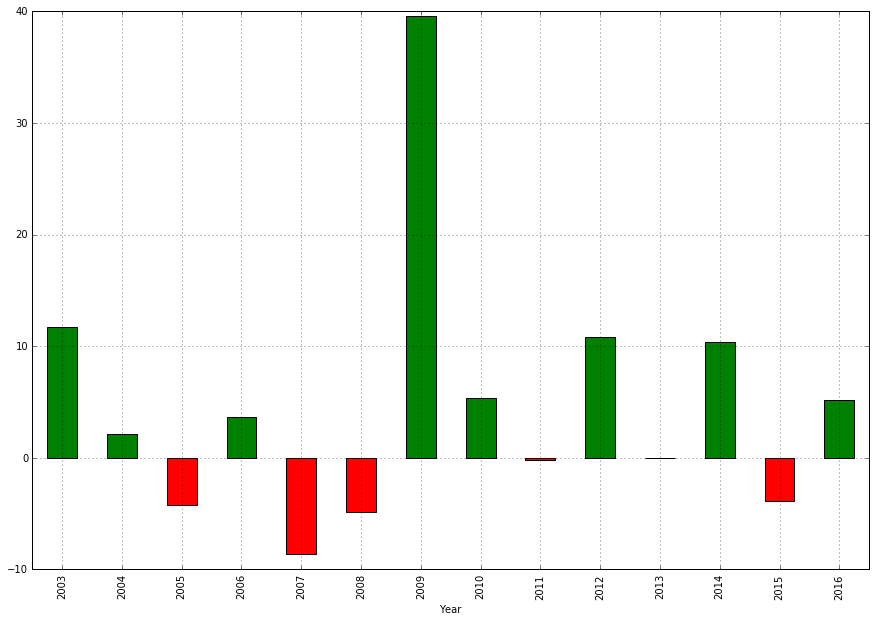

In [8]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)